## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

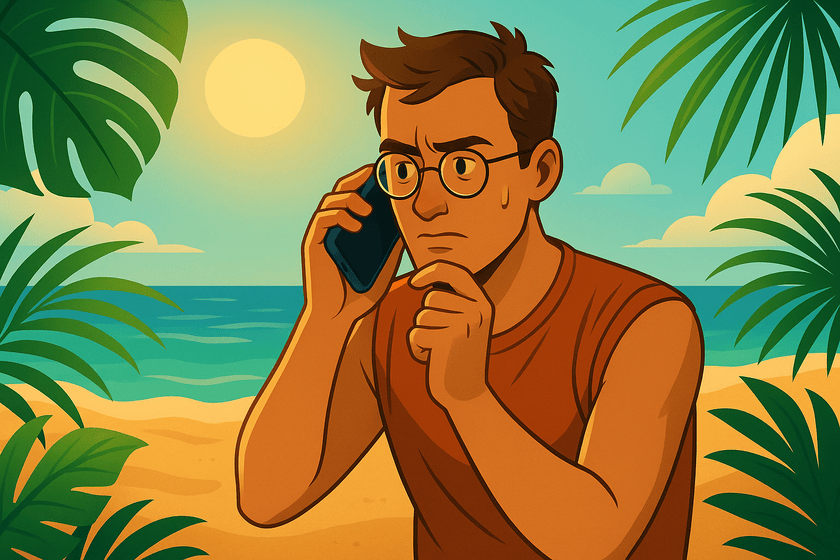

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

In [2]:
# ładowanie zbioru danych
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay,f1_score, precision_recall_fscore_support
import itertools
import time
import os
import random

Pobranie datasetu i stworzenie zbiórów: treningowy, walidacyjny i testowy.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator())

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.35MB/s]


(55000, 5000, 10000)

# NN - Baseline


Zrobiłem zwykłą sieć neuronową z 3 warstwanmi liniowymi i funkcjami aktywacji ReLu
 jako baseline do porównania przyszłych wyników sieci z warstwami konwolucyjnmi.

In [4]:
class BasicNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(28*28, 128)
    self.fc2 = nn.Linear(128,64)
    self.out = nn.Linear(64,10)

  def forward(self, x):
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x
model_NN = BasicNN()

In [6]:
from torch.optim import Adam

EPOCHS = 5
lr = 1e-3
optimizer = Adam(model_NN.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model_NN.train()
    else:
        model_NN.eval()
    for xb, yb in loader:
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model_NN(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/5 | train loss 0.2457 acc 0.9251 | val loss 0.1313 acc 0.9592
Ep 02/5 | train loss 0.1058 acc 0.9672 | val loss 0.1091 acc 0.9644
Ep 03/5 | train loss 0.0762 acc 0.9759 | val loss 0.0944 acc 0.9698
Ep 04/5 | train loss 0.0595 acc 0.9814 | val loss 0.0945 acc 0.9698
Ep 05/5 | train loss 0.0493 acc 0.9838 | val loss 0.0986 acc 0.9720
Czas treningu: 119.6s


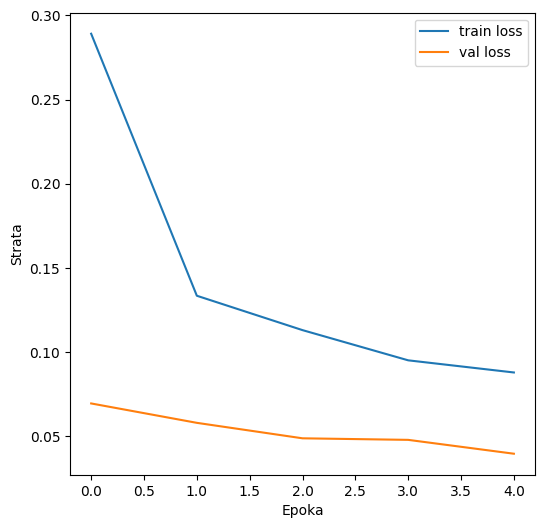

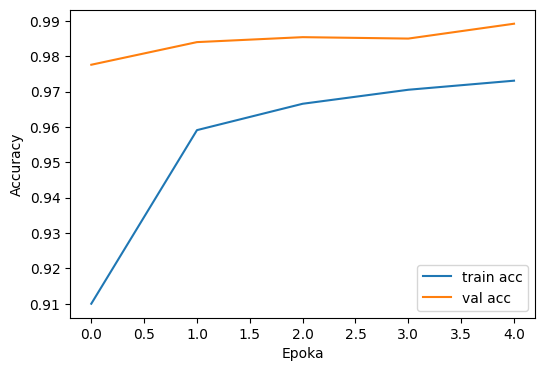

In [9]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Do ewaluacji modelu wybrałem metryki: accuracy - zbalansowe klasy, więc accuracy będzie odpowiednie, confusion matrix - można zobaczyć, które cyfry mylą się z którymi, oraz zwiuzalizowany f1 score dla każdej klasy - mimo że rozpozanwia pisma to nie jest wykrywania raka, gdzię błędy False Negative śa tragiczne w skutkach, to myślę że na wykresie zawierającym każda klasę posorotwana rosnąca według F1 można zobaczyć, przy której cyfrze nasz model najczęscięj sie myli.

Test accuracy: 0.9766


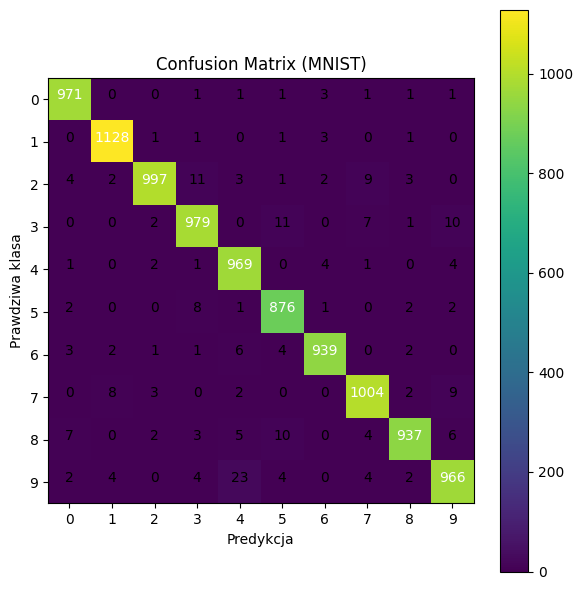

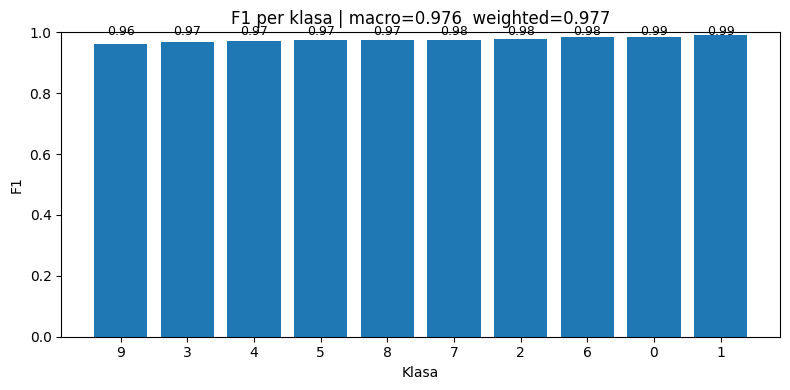

              precision    recall  f1-score   support

           0     0.9808    0.9908    0.9858       980
           1     0.9860    0.9938    0.9899      1135
           2     0.9891    0.9661    0.9775      1032
           3     0.9703    0.9693    0.9698      1010
           4     0.9594    0.9868    0.9729       982
           5     0.9648    0.9821    0.9733       892
           6     0.9863    0.9802    0.9832       958
           7     0.9748    0.9767    0.9757      1028
           8     0.9853    0.9620    0.9735       974
           9     0.9679    0.9574    0.9626      1009

    accuracy                         0.9766     10000
   macro avg     0.9765    0.9765    0.9764     10000
weighted avg     0.9767    0.9766    0.9766     10000



In [10]:
model_NN.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model_NN(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

labels = np.unique(np.concatenate([y_true, y_pred]))
p, r, f1, s = precision_recall_fscore_support(
    y_true, y_pred, labels=labels, average=None, zero_division=0
)

order = np.argsort(f1)
labels_sorted = labels[order]
f1_sorted = f1[order]

f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average="weighted", zero_division=0)

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(labels_sorted)), f1_sorted)
plt.xticks(np.arange(len(labels_sorted)), [str(l) for l in labels_sorted])
plt.ylim(0, 1.0)
plt.ylabel("F1")
plt.xlabel("Klasa")
plt.title(f"F1 per klasa | macro={f1_macro:.3f}  weighted={f1_weighted:.3f}")

for i, v in enumerate(f1_sorted):
    plt.text(i, min(v + 0.02, 0.98), f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

Zwykła sieć neuronowa dała accuracy 97% - teraz postaramy się jak najbardziej poprawić ten wynik z użyciem CNN

# CNN

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(32 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_CNN = SimpleCNN()

In [21]:
from torch.optim import Adam

EPOCHS = 5
lr = 1e-3
optimizer = Adam(model_CNN.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model_CNN.train()
    else:
        model_CNN.eval()
    for xb, yb in loader:
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model_CNN(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.1663 acc 0.9497 | val loss 0.0694 acc 0.9774
Ep 02/5 | train loss 0.1012 acc 0.9692 | val loss 0.0488 acc 0.9834
Ep 03/5 | train loss 0.0792 acc 0.9754 | val loss 0.0459 acc 0.9870
Ep 04/5 | train loss 0.0709 acc 0.9780 | val loss 0.0450 acc 0.9858
Ep 05/5 | train loss 0.0597 acc 0.9814 | val loss 0.0363 acc 0.9896
Czas treningu: 211.8s


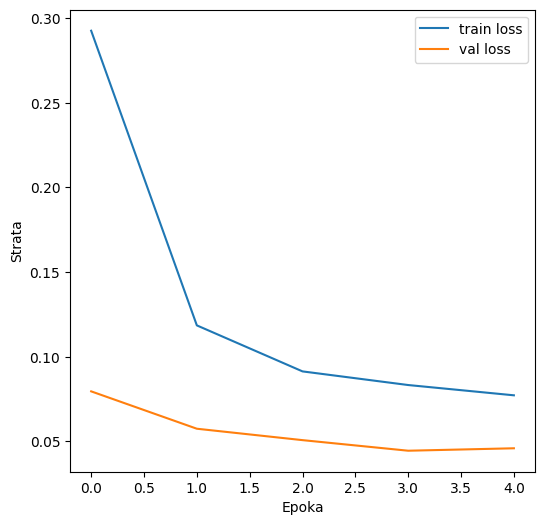

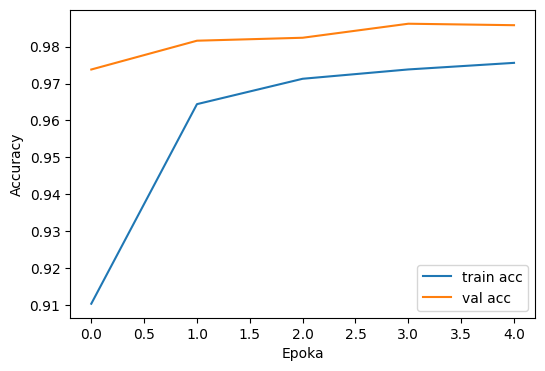

In [13]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Test accuracy: 0.9889


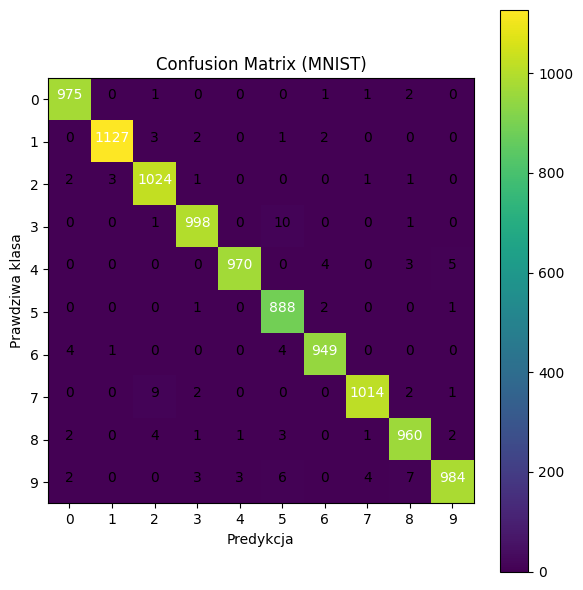

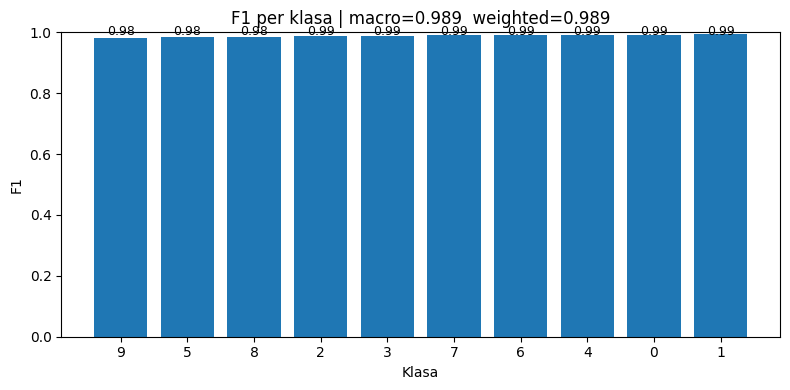

              precision    recall  f1-score   support

           0     0.9898    0.9949    0.9924       980
           1     0.9965    0.9930    0.9947      1135
           2     0.9827    0.9922    0.9875      1032
           3     0.9901    0.9881    0.9891      1010
           4     0.9959    0.9878    0.9918       982
           5     0.9737    0.9955    0.9845       892
           6     0.9906    0.9906    0.9906       958
           7     0.9931    0.9864    0.9898      1028
           8     0.9836    0.9856    0.9846       974
           9     0.9909    0.9752    0.9830      1009

    accuracy                         0.9889     10000
   macro avg     0.9887    0.9889    0.9888     10000
weighted avg     0.9890    0.9889    0.9889     10000



In [22]:
model_CNN.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model_CNN(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

labels = np.arange(10)
p, r, f1, s = precision_recall_fscore_support(
    y_true, y_pred, labels=labels, average=None, zero_division=0
)

order = np.argsort(f1)
labels_sorted = labels[order]
f1_sorted = f1[order]

f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average="weighted", zero_division=0)

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(labels_sorted)), f1_sorted)
plt.xticks(np.arange(len(labels_sorted)), [str(l) for l in labels_sorted])
plt.ylim(0, 1.0)
plt.ylabel("F1")
plt.xlabel("Klasa")
plt.title(f"F1 per klasa | macro={f1_macro:.3f}  weighted={f1_weighted:.3f}")

for i, v in enumerate(f1_sorted):
    plt.text(i, min(v + 0.02, 0.98), f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

Po kilkukrontych próbach dobrania lepszej struktury sieci nie udało mi się uzyskać lepszej niż startowa - 99.3% (próby, które podjąłem miały podobną dokładność - nieco poniżej 99%), zostawie jedną z prób zamiast tej zaproponowanej w notebooku, żeby było coś innego

# Testowanie różnych dropoutów

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        #self.dropout = nn.Dropout(0.1)
        self.fc1  = nn.Linear(32 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.fc2(x)
        return x

model_CNN = SimpleCNN()

In [24]:
from torch.optim import Adam

EPOCHS = 5
lr = 1e-3
optimizer = Adam(model_CNN.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model_CNN.train()
    else:
        model_CNN.eval()
    for xb, yb in loader:
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model_CNN(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.1370 acc 0.9584 | val loss 0.0620 acc 0.9812
Ep 02/5 | train loss 0.0457 acc 0.9856 | val loss 0.0649 acc 0.9808
Ep 03/5 | train loss 0.0310 acc 0.9905 | val loss 0.0501 acc 0.9864
Ep 04/5 | train loss 0.0235 acc 0.9925 | val loss 0.0470 acc 0.9858
Ep 05/5 | train loss 0.0159 acc 0.9947 | val loss 0.0538 acc 0.9854
Czas treningu: 235.5s


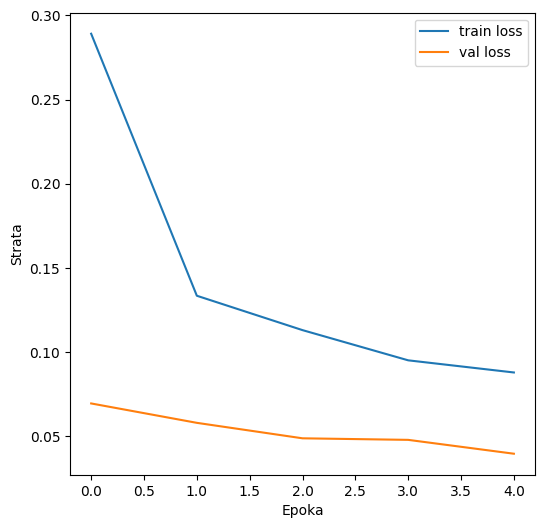

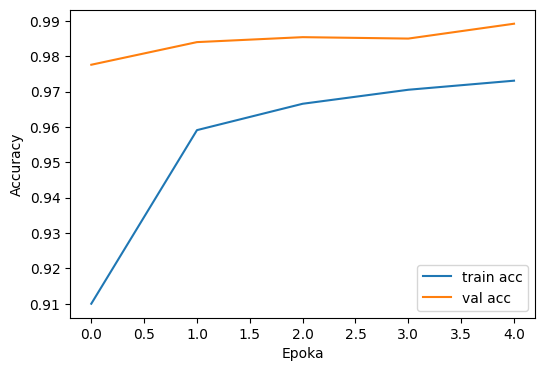

In [12]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Test accuracy: 0.9882


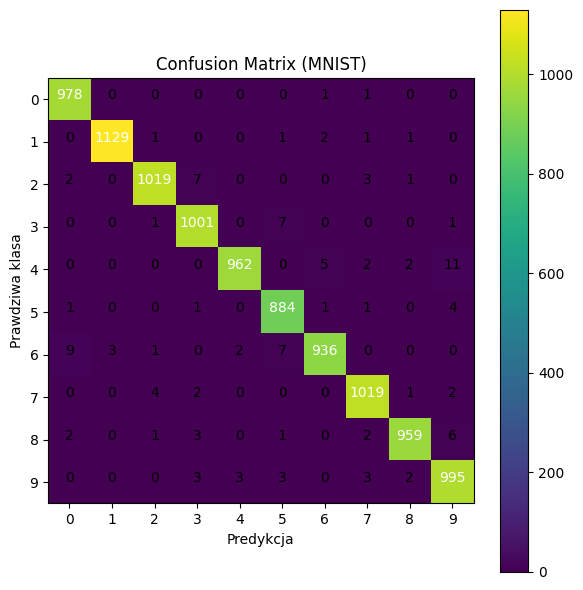

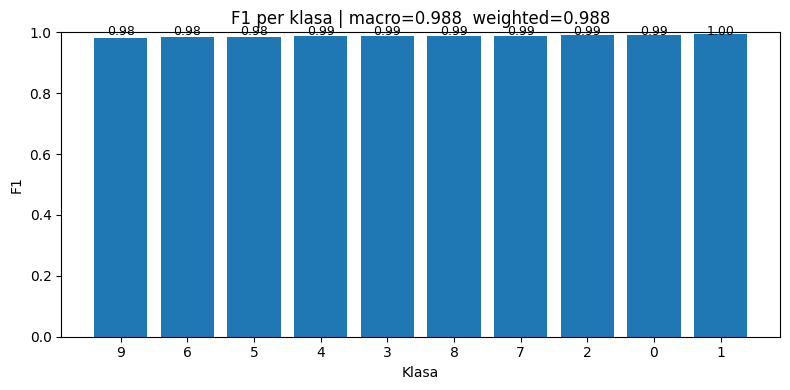

              precision    recall  f1-score   support

           0     0.9859    0.9980    0.9919       980
           1     0.9973    0.9947    0.9960      1135
           2     0.9922    0.9874    0.9898      1032
           3     0.9843    0.9911    0.9877      1010
           4     0.9948    0.9796    0.9872       982
           5     0.9790    0.9910    0.9850       892
           6     0.9905    0.9770    0.9837       958
           7     0.9874    0.9912    0.9893      1028
           8     0.9928    0.9846    0.9887       974
           9     0.9764    0.9861    0.9813      1009

    accuracy                         0.9882     10000
   macro avg     0.9881    0.9881    0.9880     10000
weighted avg     0.9882    0.9882    0.9882     10000



In [25]:
model_CNN.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model_CNN(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

labels = np.arange(10)
p, r, f1, s = precision_recall_fscore_support(
    y_true, y_pred, labels=labels, average=None, zero_division=0
)

order = np.argsort(f1)
labels_sorted = labels[order]
f1_sorted = f1[order]

f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average="weighted", zero_division=0)

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(labels_sorted)), f1_sorted)
plt.xticks(np.arange(len(labels_sorted)), [str(l) for l in labels_sorted])
plt.ylim(0, 1.0)
plt.ylabel("F1")
plt.xlabel("Klasa")
plt.title(f"F1 per klasa | macro={f1_macro:.3f}  weighted={f1_weighted:.3f}")

for i, v in enumerate(f1_sorted):
    plt.text(i, min(v + 0.02, 0.98), f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

Dropout od 0.1 do 0.3 dawał dobre wyniki około 99%, brak dropoutu nie zmienił żadnych wyników - dalej około 99% accuracy, za to dropout 0.5 kompletnie nie działał

# Dodanie BatchNorm

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(32 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_CNN = SimpleCNN()

In [27]:
from torch.optim import Adam

EPOCHS = 5
lr = 1e-3
optimizer = Adam(model_CNN.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model_CNN.train()
    else:
        model_CNN.eval()
    for xb, yb in loader:
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model_CNN(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/5 | train loss 0.1612 acc 0.9509 | val loss 0.0665 acc 0.9770
Ep 02/5 | train loss 0.0730 acc 0.9780 | val loss 0.0436 acc 0.9876
Ep 03/5 | train loss 0.0578 acc 0.9820 | val loss 0.0399 acc 0.9878
Ep 04/5 | train loss 0.0524 acc 0.9840 | val loss 0.0409 acc 0.9874
Ep 05/5 | train loss 0.0405 acc 0.9870 | val loss 0.0369 acc 0.9896
Czas treningu: 277.0s


In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Test accuracy: 0.9912


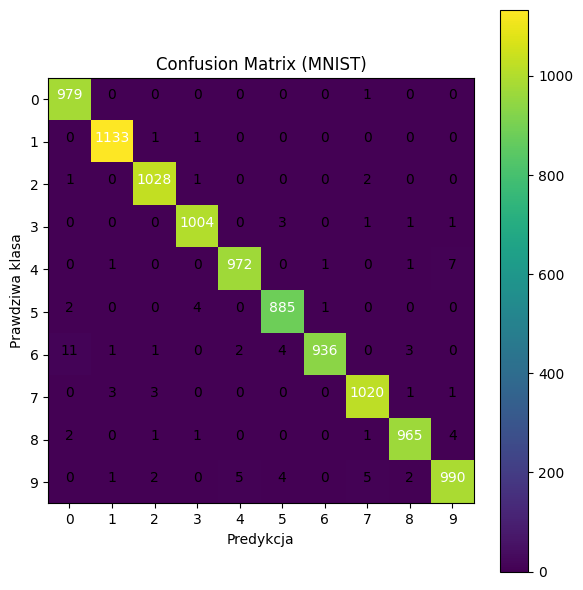

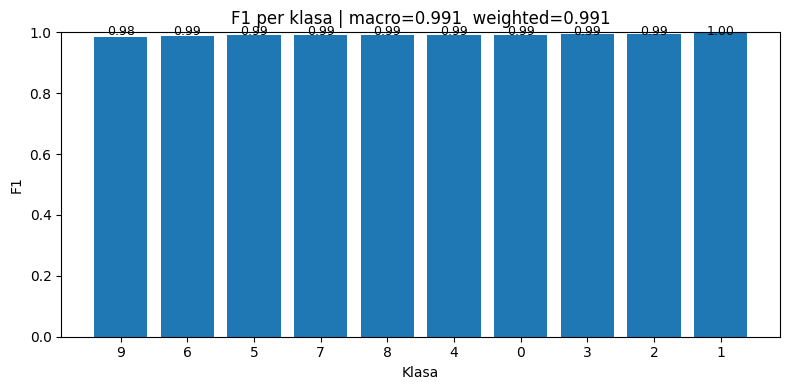

              precision    recall  f1-score   support

           0     0.9839    0.9990    0.9914       980
           1     0.9947    0.9982    0.9965      1135
           2     0.9923    0.9961    0.9942      1032
           3     0.9931    0.9941    0.9936      1010
           4     0.9928    0.9898    0.9913       982
           5     0.9877    0.9922    0.9899       892
           6     0.9979    0.9770    0.9873       958
           7     0.9903    0.9922    0.9913      1028
           8     0.9918    0.9908    0.9913       974
           9     0.9870    0.9812    0.9841      1009

    accuracy                         0.9912     10000
   macro avg     0.9912    0.9911    0.9911     10000
weighted avg     0.9912    0.9912    0.9912     10000



In [29]:
model_CNN.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model_CNN(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

labels = np.arange(10)
p, r, f1, s = precision_recall_fscore_support(
    y_true, y_pred, labels=labels, average=None, zero_division=0
)

order = np.argsort(f1)
labels_sorted = labels[order]
f1_sorted = f1[order]

f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average="weighted", zero_division=0)

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(labels_sorted)), f1_sorted)
plt.xticks(np.arange(len(labels_sorted)), [str(l) for l in labels_sorted])
plt.ylim(0, 1.0)
plt.ylabel("F1")
plt.xlabel("Klasa")
plt.title(f"F1 per klasa | macro={f1_macro:.3f}  weighted={f1_weighted:.3f}")

for i, v in enumerate(f1_sorted):
    plt.text(i, min(v + 0.02, 0.98), f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

Dodanie batchnorm lekko polepszyło wynik

# Które liczby są najczęściej mylone?
Najczęsciej źle predykowana jest liczba 9, która najczęściej mylona jest z liczbą 4. Wydaje mi się, że to przez to, że w miarę podobne(przy 9 zaokrąglona część na górze, a przy 4 taki jakby trójkąt) "Główne" części liczb znajdują się na górze i model czasami je myli przy np. lekkim zaokrągleiniu przy pisaniu liczby 4 u góry

```
# Sformatowano jako kod
```



Dalsze testy zmian architekutry w tym dodanie BatchNorm, oraz wypisywanie wniosków dokończe w poniedziałek/wtorek, bo nie zdążyłem w niedziele.